# Introduction
## Sales Forecasting Model with SARIMAX
This repository contains a base sales forecasting model built in Python using the SARIMAX method from the statsmodels library. The SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model predicts weekly sales while explicitly accounting for the impact of external factors such as advertising spend metrics. Specifically, the model incorporates Digital Ads, Offline Ads, TVCM_GPR, and Print Media as external regressors to enhance forecasting accuracy.

◾️ Data Cleaning and Preprocessing
- Data Import: Raw data is imported from a CSV file.
- Date Handling: Dates are converted to datetime format to properly handle the time-series nature of the data.
- Numeric Cleaning: Numeric columns such as Sales and advertising spend metrics (Digital Ads, Offline Ads, TVCM_GPR, and Print Media) are cleaned and processed to ensure consistency.

◾️ Model Building
- SARIMAX Model: The SARIMAX model explicitly incorporates external regressors (Digital Ads, Offline Ads, TVCM_GPR, and Print Media) to improve predictive accuracy.
- Seasonality: Seasonal patterns are explicitly modeled by setting seasonal parameters, capturing annual seasonality (with a frequency of 52 weeks per year).

◾️ Model Evaluation
- Train/Test Split: The historical data is split into training and testing sets for initial model evaluation, using metrics such as RMSE, MAE, and MAPE to assess performance.

◾️ Forecasting
- Future Predictions: The model provides forecasts for specified future dates based on external regressors provided for these periods.
- Visualization: Forecasted values are visualized alongside historical sales data, allowing easy comparison of actual and predicted sales.

This SARIMAX model serves as a foundational framework, demonstrating moderate predictive accuracy. Further improvements, such as hyperparameter tuning and advanced feature engineering, can enhance its forecasting capability.

In [22]:
import numpy as np
import pandas as pd
import datetime

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['font.size'] = 14

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
dataset = "../data/sales_data.csv"
df = pd.read_csv(dataset)

# Preprocess

In [24]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')

df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         121 non-null    datetime64[ns]
 1   Sales        121 non-null    int64         
 2   TVCM_GPR     121 non-null    float64       
 3   Print_Media  121 non-null    int64         
 4   Offline_Ads  121 non-null    int64         
 5   Digital_Ads  121 non-null    int64         
 6   Record_Type  121 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 6.7+ KB


In [25]:
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

df_actual = df_actual[['Date', 'Sales', 'Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']]
df_forecast = df_forecast[['Date', 'Sales', 'Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']]

df_actual = df_actual.sort_values('Date')
df_forecast = df_forecast.sort_values('Date')
df_actual = df_actual.set_index('Date').sort_index()

df_forecast = df_forecast.set_index('Date').sort_index()


In [26]:
df_actual.head()

,Sales,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media
Date,,,,,
2015-09-07,5554981,23080,5890000,58.86750,20340000
2015-09-14,6071669,29979,5740000,235.18125,15470000
2015-09-21,5798657,23784,0,252.18375,8325000
2015-09-28,6235157,26732,0,75.25500,0
2015-10-05,6861105,28823,0,0.00000,0


In [27]:
df_forecast.head()

,Sales,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media
Date,,,,,
2017-09-11,0,23830,5740000,235.18125,15470000
2017-09-18,0,26072,0,252.18375,8325000
2017-09-25,0,29948,0,75.25500,0
2017-10-02,0,34220,0,0.00000,0
2017-10-09,0,29145,0,44.62125,0


# Test Train Split

In [28]:
train, test = train_test_split(df_actual, test_size=12)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

exog_cols = ['Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']
train_endog = train['Sales']
train_exog = train[exog_cols]
test_endog = test['Sales']
test_exog = test[exog_cols]

Train shape: (93, 5)
Test shape : (12, 5)


# Visualize the Test / Train Data

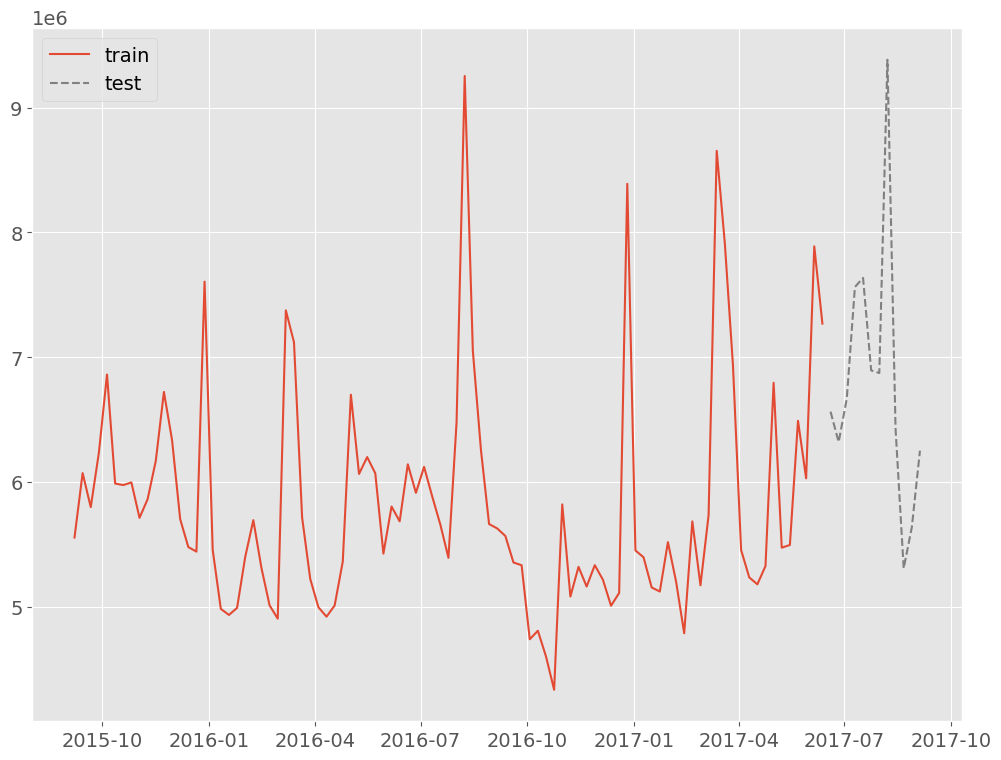

In [36]:
fig, ax = plt.subplots()

ax.plot(
    train.index,
    train.Sales.values,
    linestyle='-',
    label='train'
)

ax.plot(
    test.index,
    test.Sales.values,
    linestyle='--',
    label='test',
    color='gray'
)

# ax.axvline(
#     2017-9-11,
#     color='blue')
ax.legend()
plt.show()

# SARIMA Model

In [37]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)  # weekly data with yearly seasonality

print("\n--- Fitting SARIMAX model ---")
model = SARIMAX(
    endog=train_endog,
    exog=train_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())



--- Fitting SARIMAX model ---
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Thu, 13 Mar 2025   AIC                             18.000
Time:                                    10:20:03   BIC                                nan
Sample:                                09-07-2015   HQIC                               nan
                                     - 06-12-2017                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Digital_Ads     5.3123         -0       -inf      0.000       5.312       5.312
O

# Evaluation

In [38]:
steps = len(test_endog)

forecast_obj_test = results.get_forecast(steps=steps, exog=test_exog)

df_test_forecast = forecast_obj_test.summary_frame()

df_test_forecast.rename(columns={
    'mean': 'yhat',
    'mean_ci_lower': 'yhat_lower',
    'mean_ci_upper': 'yhat_upper'
}, inplace=True)

df_test_forecast.index = test_endog.index

df_test_forecast['Sales'] = test_endog

rmse = np.sqrt(mean_squared_error(df_test_forecast['Sales'], df_test_forecast['yhat']))
mae  = mean_absolute_error(df_test_forecast['Sales'], df_test_forecast['yhat'])
mape = mean_absolute_percentage_error(df_test_forecast['Sales'], df_test_forecast['yhat'])

print("\n==== Test Evaluation ====")
print("RMSE:", rmse)
print("MAE: ", mae)
print("MAPE:", mape)


==== Test Evaluation ====
RMSE: 880250.6340449842
MAE:  724412.9877627274
MAPE: 0.11542426505044635


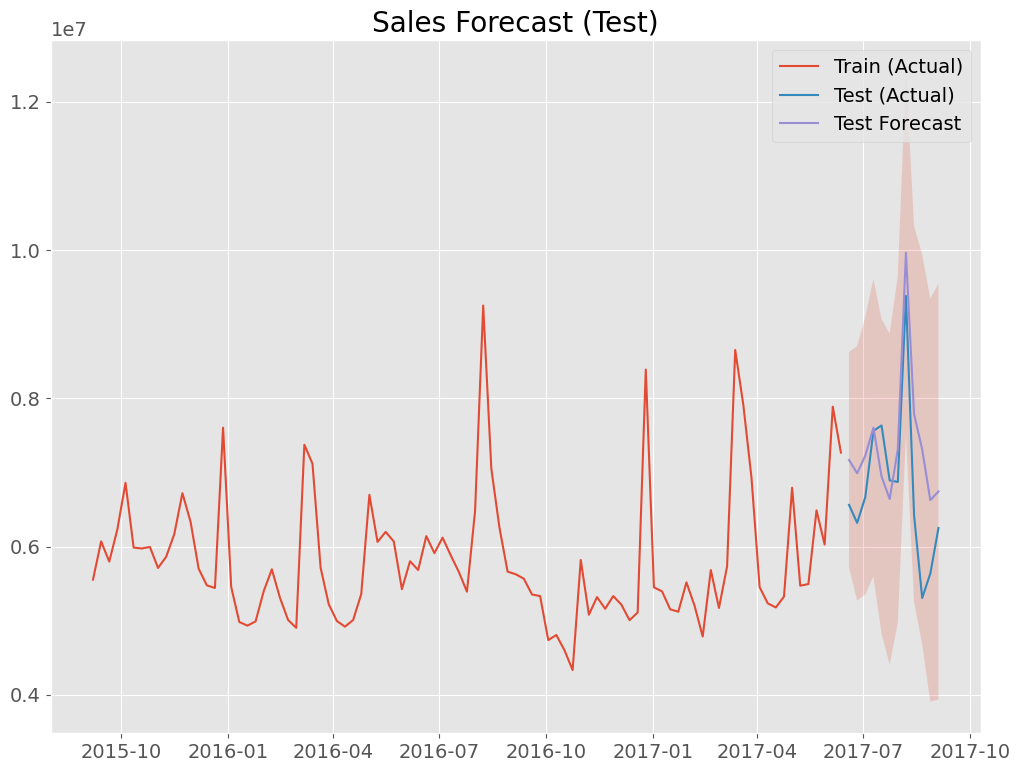

In [39]:

plt.figure()
plt.plot(train.index, train['Sales'], label='Train (Actual)')
plt.plot(test.index, test['Sales'], label='Test (Actual)')

plt.plot(df_test_forecast.index, df_test_forecast['yhat'], label='Test Forecast')

plt.fill_between(df_test_forecast.index,
                 df_test_forecast['yhat_lower'],
                 df_test_forecast['yhat_upper'],
                 alpha=0.2)

plt.title('Sales Forecast (Test)')
plt.legend()
plt.show()

# Forecast

In [40]:
df_forecast = df_forecast.copy()
df_forecast.index = pd.to_datetime(df_forecast.index)  
df_forecast = df_forecast.sort_index() 

In [41]:
exog_cols = ['Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']

steps_forecast = len(df_forecast)  
future_exog = df_forecast[exog_cols]

future_forecast_obj = results.get_forecast(
    steps=steps_forecast,
    exog=future_exog
)

df_future_forecast = future_forecast_obj.summary_frame()

df_future_forecast.rename(columns={
    'mean': 'yhat',
    'mean_ci_lower': 'yhat_lower',
    'mean_ci_upper': 'yhat_upper'
}, inplace=True)

df_future_forecast.index = df_forecast.index  

In [42]:
df_forecast['Sales'] = df_future_forecast['yhat'].values
df_forecast['yhat_lower'] = df_future_forecast['yhat_lower'].values
df_forecast['yhat_upper'] = df_future_forecast['yhat_upper'].values

In [43]:
df_forecast

,Sales,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media,yhat_lower,yhat_upper
Date,,,,,,,
2017-09-11,7.091898e+06,23830,5740000,235.18125,15470000,5.637624e+06,8.546172e+06
2017-09-18,6.960374e+06,26072,0,252.18375,8325000,5.244323e+06,8.676425e+06
2017-09-25,6.918903e+06,29948,0,75.25500,0,5.043910e+06,8.793896e+06
2017-10-02,6.658711e+06,34220,0,0.00000,0,4.653446e+06,8.663975e+06
2017-10-09,6.422002e+06,29145,0,44.62125,0,4.298651e+06,8.545354e+06
2017-10-16,6.186377e+06,25991,0,50.16750,0,3.952306e+06,8.420449e+06
2017-10-23,6.892209e+06,18571,8360000,46.60875,0,4.552961e+06,9.231457e+06
2017-10-30,9.756667e+06,32704,8710000,115.46625,15900000,7.316857e+06,1.219648e+07
2017-11-06,7.714359e+06,29000,9050000,185.66250,7835000,5.177994e+06,1.025072e+07


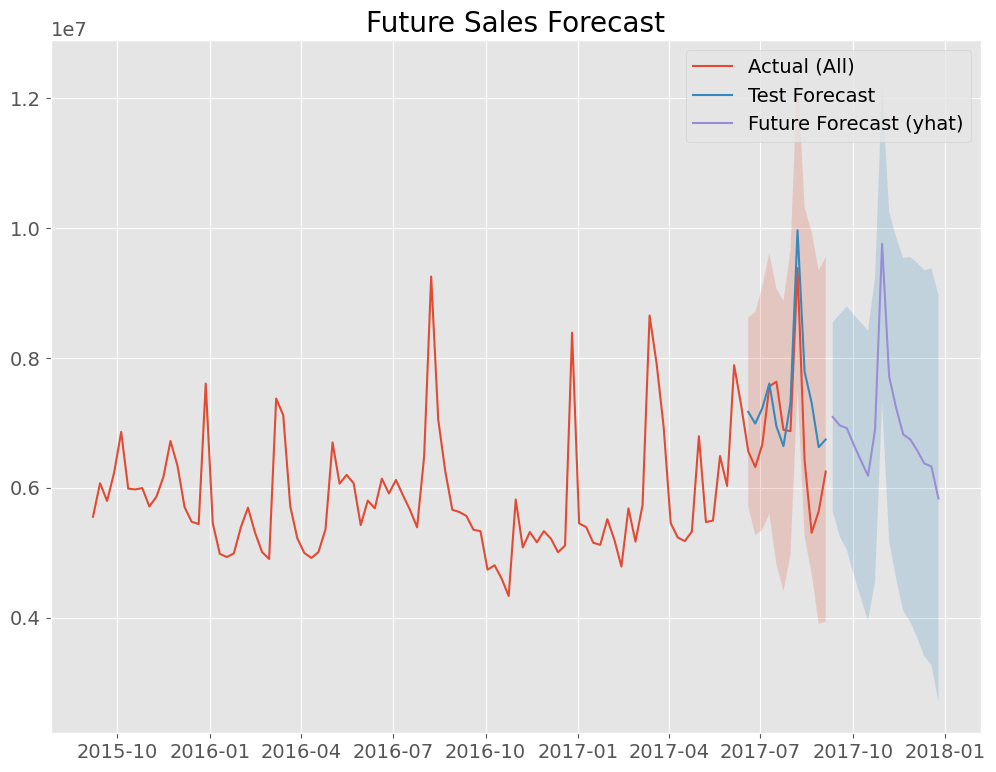

In [44]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(df_actual.index, df_actual['Sales'], label='Actual (All)')

plt.plot(df_test_forecast.index, df_test_forecast['yhat'], label='Test Forecast')
plt.fill_between(df_test_forecast.index,
                 df_test_forecast['yhat_lower'],
                 df_test_forecast['yhat_upper'],
                 alpha=0.2)

plt.plot(df_forecast.index, df_forecast['Sales'], label='Future Forecast (yhat)')

if 'yhat_lower' in df_forecast.columns:
    plt.fill_between(df_forecast.index,
                     df_forecast['yhat_lower'],
                     df_forecast['yhat_upper'],
                     alpha=0.2)

plt.title('Future Sales Forecast')
plt.legend()
plt.show()

# Conclusion

The forecasting horizon was very short, which limited the model's ability to fully capture the underlying seasonal patterns and trends. As a result, the predictions were not as accurate as expected. In future work, extending the historical data and increasing the forecasting period may improve the model's performance and provide more reliable forecasts.